# AlongTrack Evaluation

In [1]:
import autoroot
import typing as tp
from dataclasses import dataclass
import functools as ft
import numpy as np
import pandas as pd
import xarray as xr
import einops
from metpy.units import units
import pint_xarray
import xarray_dataclasses as xrdataclass
from oceanbench._src.datasets.base import XRDABatcher
from oceanbench._src.geoprocessing.spatial import transform_360_to_180
from oceanbench._src.geoprocessing.subset import where_slice
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2


## Data

In [2]:
!ls "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/results"

OSE_ssh_mapping_4dvarNet_2022.nc  OSE_ssh_mapping_DUACS.nc
OSE_ssh_mapping_4dvarNet.nc	  OSE_ssh_mapping_DYMOST.nc
OSE_ssh_mapping_BASELINE.nc	  OSE_ssh_mapping_MIOST.nc
OSE_ssh_mapping_BFN.nc


In [3]:

!ls /gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/test

dt_gulfstream_c2_phy_l3_20161201-20180131_285-315_23-53.nc


In [4]:
files_nadir_dc21a = [
    "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/test/dt_gulfstream_c2_phy_l3_20161201-20180131_285-315_23-53.nc",
]


ds_nadir = xr.open_dataset(files_nadir_dc21a[0])

In [5]:
ds_nadir

<xarray.Dataset>
Dimensions:         (time: 427211)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-01T09:33:32.200930048 ... 2...
    longitude       (time) float64 ...
    latitude        (time) float64 ...
Data variables:
    cycle           (time) float64 ...
    track           (time) float64 ...
    dac             (time) float32 ...
    lwe             (time) float32 ...
    mdt             (time) float32 ...
    ocean_tide      (time) float64 ...
    sla_filtered    (time) float32 ...
    sla_unfiltered  (time) float32 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H43M4.754863S
    time_coverage_end:               2016-01-01T23:11:03Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:27:58Z
    title:                           DT Cryosat-2 Global Ocean Along track SS...

In [6]:
def preprocess_nadir_dc21a(da, variable="ssh_mod"):
            
    da = da.sel(
        # time=slice("2017-01-01", "2018-01-01"),
        drop=True
    ).compute()
    
    da = da.rename({"longitude": "lon", "latitude": "lat"})
    
    da["lon"] = transform_360_to_180(da["lon"])
    
    # calculate SSH directly
    da["ssh"] = da["sla_unfiltered"] + da["mdt"] - da["lwe"]
    
    da = where_slice(da, "lon", -64.975, -55.007)
    da = where_slice(da, "lat", 33.025, 42.9917)
            
    return da

In [7]:
transform_360_to_180(np.asarray([295, 305]))

array([-65, -55])

In [8]:
preprocess_fn = ft.partial(preprocess_nadir_dc21a, variable="sla_unfiltered")

ds_nadir = xr.open_mfdataset(
    files_nadir_dc21a, 
    preprocess=preprocess_fn,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_nadir = ds_nadir.sortby("time")

ds_nadir

<xarray.Dataset>
Dimensions:         (time: 58079)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-01T09:36:17.295930112 ... 2...
    lon             (time) float64 -61.46 -61.47 -61.47 ... -60.36 -60.37 -60.38
    lat             (time) float64 33.07 33.13 33.18 33.24 ... 33.17 33.12 33.06
Data variables:
    cycle           (time) float64 87.0 87.0 87.0 87.0 ... 102.0 102.0 102.0
    track           (time) float64 643.0 643.0 643.0 643.0 ... 368.0 368.0 368.0
    dac             (time) float32 -0.0885 -0.088 -0.0874 ... -0.1561 -0.1559
    lwe             (time) float32 0.003 0.003 0.003 0.003 ... 0.012 0.012 0.012
    mdt             (time) float32 0.579 0.579 0.579 0.578 ... 0.572 0.572 0.571
    ocean_tide      (time) float64 -0.0386 -0.0385 -0.0384 ... 0.1126 0.1121
    sla_filtered    (time) float32 0.078 0.069 0.062 0.056 ... 0.151 0.146 0.14
    sla_unfiltered  (time) float32 0.056 0.078 0.051 0.046 ... 0.159 0.136 0.134
    ssh             (time) float32 0.632 0.654 0.627 0.621 ... 0.719 0.696 0.693
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H43M4.754863S
    time_coverage_end:               2016-01-01T23:11:03Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:27:58Z
    title:                           DT Cryosat-2 Global Ocean Along track SS...

In [9]:
ds_nadir.lon.min(), ds_nadir.lon.max(), ds_nadir.lat.min(), ds_nadir.lat.max()

(<xarray.DataArray 'lon' ()>
 array(-64.974907),
 <xarray.DataArray 'lon' ()>
 array(-55.007537),
 <xarray.DataArray 'lat' ()>
 array(33.025009),
 <xarray.DataArray 'lat' ()>
 array(42.991672))

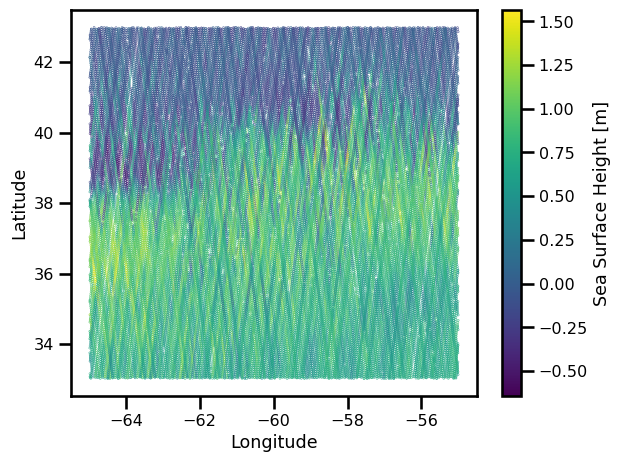

In [10]:
%matplotlib inline

fig, ax = plt.subplots()

sub_ds = ds_nadir.isel(time=slice(0,None))
pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds.ssh, s=0.1)
ax.set(
    xlabel="Longitude",
    ylabel="Latitude",
)

plt.colorbar(pts, label="Sea Surface Height [m]")
plt.tight_layout()
plt.show()

## Data Structure

## Gridding

In [11]:
# !ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/natl60/
!ls /gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/results

OSE_ssh_mapping_4dvarNet_2022.nc  OSE_ssh_mapping_DUACS.nc
OSE_ssh_mapping_4dvarNet.nc	  OSE_ssh_mapping_DYMOST.nc
OSE_ssh_mapping_BASELINE.nc	  OSE_ssh_mapping_MIOST.nc
OSE_ssh_mapping_BFN.nc


In [75]:
file_DUACS = "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/results/OSE_ssh_mapping_BFN.nc"


In [76]:
def open_ose_reference(file, variable="gssh"):
    da = xr.open_dataset(file, decode_times=True)
    da = da.sortby("time")
    da["lon"] = transform_360_to_180(da["lon"])
    da = da.sel(
        time=slice("2017-01-01", "2018-01-01"),
        lon=slice(-64.975, -55.007),
        lat=slice(33.025, 42.9917),
        drop=True
    )
    return da

In [77]:
# ds_natl60 = open_ssh_reference(file_natl60, "ssh")
ds_duacs = open_ose_reference(file_DUACS, "ssh")
ds_duacs

<xarray.Dataset>
Dimensions:  (time: 8760, lat: 100, lon: 100)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T01:00:00 ... 2018-01-01
  * lat      (lat) float32 33.06 33.16 33.26 33.36 ... 42.66 42.76 42.86 42.96
  * lon      (lon) float32 -64.94 -64.84 -64.74 -64.64 ... -55.24 -55.14 -55.04
Data variables:
    ssh      (time, lat, lon) float64 ...
Attributes:
    history:  Tue Apr 27 09:56:10 2021: ncrename -v SSH,ssh OSE_ssh_mapping_B...
    NCO:      4.6.6

In [78]:
import pyinterp


In [79]:
from oceanbench._src.geoprocessing.gridding import grid_to_coord_based

In [80]:
ds_nadir["ssh_interp"] = grid_to_coord_based(
    ds_duacs.transpose("lon", "lat", "time"),
    ds_nadir,
    data_vars=["ssh"], 
)["ssh"]
# np.isfinite(ds_nadir_gridded.ssh.isel(time=6)).plot.imshow()

In [98]:
ds_results = ds_nadir.copy()

# drop all nans
ds_results = ds_results[["ssh", "ssh_interp"]].dropna(dim="time")

ds_results = where_slice(ds_results, "lon", -64.975 - 0.25, -55.007 + 0.25)
ds_results = where_slice(ds_results, "lat", 33.025 - 0.25, 42.9917 + 0.25)

In [99]:
ds_results

<xarray.Dataset>
Dimensions:     (time: 48830)
Coordinates:
  * time        (time) datetime64[ns] 2017-01-01T08:08:42.956040704 ... 2017-...
    lon         (time) float64 -62.61 -62.62 -62.63 ... -62.09 -62.1 -62.1
    lat         (time) float64 33.09 33.15 33.2 33.26 ... 42.83 42.89 42.95
Data variables:
    ssh         (time) float32 0.47 0.43 0.404 0.364 ... -0.055 -0.038 -0.02
    ssh_interp  (time) float64 0.4206 0.413 0.4135 ... -4.194e-19 -5.766e-20
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H43M4.754863S
    time_coverage_end:               2016-01-01T23:11:03Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:27:58Z
    title:                           DT Cryosat-2 Global Ocean Along track SS...

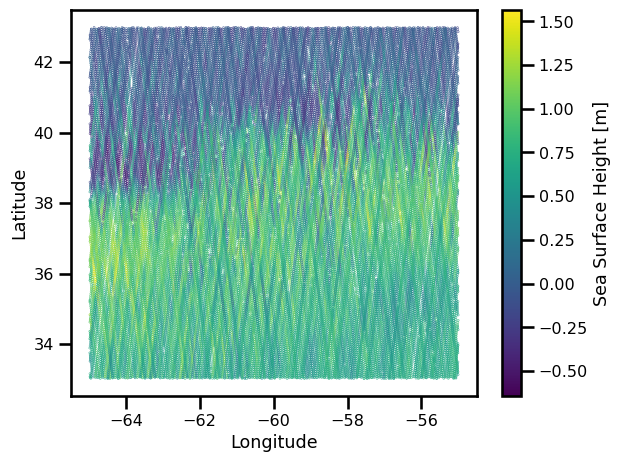

In [100]:
%matplotlib inline

fig, ax = plt.subplots()

sub_ds = ds_nadir.isel(time=slice(0,None))
pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds.ssh, s=0.1)
ax.set(
    xlabel="Longitude",
    ylabel="Latitude",
)

plt.colorbar(pts, label="Sea Surface Height [m]")
plt.tight_layout()
plt.show()

In [164]:
velocity = 6.77 # [km/s]
delta_t = 0.9434 # [s]
delta_x = velocity * delta_t # [km]
length_scale = 1000 # [km]

In [165]:
import oceanbench._src.preprocessing.alongtrack as atrack_process
import oceanbench._src.metrics.power_spectrum as psd_calc

In [168]:
ds_segments = atrack_process.select_track_segments(
    ds_results,
    "ssh", "ssh_interp",
)
ds_segments

<xarray.Dataset>
Dimensions:     (segment: 228, track_val: 156)
Coordinates:
  * segment     (segment) int64 0 1 2 3 4 5 6 7 ... 221 222 223 224 225 226 227
    lat         (segment) float64 -63.16 -61.22 -64.02 ... -57.66 -60.52 -58.55
    lon         (segment) float64 37.57 38.48 37.43 38.54 ... 38.52 37.48 38.59
  * track_val   (track_val) int64 0 1 2 3 4 5 6 ... 149 150 151 152 153 154 155
Data variables:
    ssh_interp  (segment, track_val) float64 0.4206 0.413 0.4135 ... 0.7076 0.71
    ssh         (segment, track_val) float32 0.47 0.43 0.404 ... 0.765 0.691

In [169]:
nperseg = ds_segments.ssh.nperseg
nperseg

156

## Statistics

In [170]:
psd_calc.psd_welch_score(ds_segments, "ssh", "ssh_interp", delta_x=delta_x, nperseg=nperseg).score

<xarray.DataArray 'score' (wavenumber: 79)>
array([  0.98321019,   0.98599161,   0.9706814 ,   0.94872133,
         0.88745469,   0.73220097,   0.68894638,   0.40250576,
         0.06545214,  -0.40825877,  -0.94819535,  -1.66471146,
        -2.48071657,  -3.59591937,  -5.05576922,  -7.01627059,
        -7.95458546,  -7.44640267,  -8.82443478,  -9.89159498,
       -12.40995497, -12.34148269, -12.14423515, -12.07263471,
       -13.66178972, -16.71048917, -17.64082654, -18.4768189 ,
       -18.68388056, -18.732039  , -19.32886202, -20.83372606,
       -18.29259447, -18.91349907, -21.3910767 , -24.25155896,
       -24.77242347, -24.28042916, -23.47089013, -25.90348945,
       -28.73703758, -29.38145285, -29.22721435, -29.38951696,
       -25.94089753, -25.83150188, -29.93063041, -29.83275097,
       -32.07702064, -31.65573757, -31.20075074, -36.84437852,
       -38.84032339, -43.81677473, -39.36669595, -38.36411627,
       -36.80902965, -41.8369051 , -42.37494581, -41.87190811,
       -41.50736294, -42.29917181, -44.26879548, -47.96239427,
       -50.6953158 , -46.3404239 , -43.65336424, -43.87850165,
       -46.63090099, -45.18568003, -41.20070175, -46.99822902,
       -44.71189787, -44.52547619, -46.21408113, -47.39966311,
       -49.47181739, -46.44888004, -43.79081993])
Coordinates:
  * wavenumber  (wavenumber) float64 0.0 0.001004 0.002007 ... 0.07728 0.07829

## PSD

In [171]:
# SSH AlongTrack
ds_psd = psd_calc.psd_welch(ds_segments, "ssh", delta_x=delta_x, nperseg=nperseg)



# SSH Interpolated Map
ds_psd["ssh_interp"] = psd_calc.psd_welch(ds_segments, "ssh_interp", delta_x=delta_x, nperseg=nperseg).ssh_interp


# PSD Error
ds_psd["error"] = psd_calc.psd_welch_error(ds_segments, "ssh", "ssh_interp", delta_x=delta_x, nperseg=nperseg).error

# PSD Score
ds_psd["score"] = psd_calc.psd_welch_score(ds_segments, "ssh", "ssh_interp", delta_x=delta_x, nperseg=nperseg).score

ds_psd

<xarray.Dataset>
Dimensions:     (wavenumber: 79)
Coordinates:
  * wavenumber  (wavenumber) float64 0.0 0.001004 0.002007 ... 0.07728 0.07829
Data variables:
    ssh         (wavenumber) float32 10.03 73.1 42.6 ... 0.007124 0.003353
    ssh_interp  (wavenumber) float64 9.978 72.53 40.43 ... 0.0001447 7.323e-05
    error       (wavenumber) float64 0.1675 1.016 1.185 ... 0.006867 0.00328
    score       (wavenumber) float64 0.9832 0.986 0.9707 ... -46.45 -43.79

In [184]:
ds_psd["score"]

<xarray.DataArray 'score' (wavenumber: 79)>
array([  0.98321019,   0.98599161,   0.9706814 ,   0.94872133,
         0.88745469,   0.73220097,   0.68894638,   0.40250576,
         0.06545214,  -0.40825877,  -0.94819535,  -1.66471146,
        -2.48071657,  -3.59591937,  -5.05576922,  -7.01627059,
        -7.95458546,  -7.44640267,  -8.82443478,  -9.89159498,
       -12.40995497, -12.34148269, -12.14423515, -12.07263471,
       -13.66178972, -16.71048917, -17.64082654, -18.4768189 ,
       -18.68388056, -18.732039  , -19.32886202, -20.83372606,
       -18.29259447, -18.91349907, -21.3910767 , -24.25155896,
       -24.77242347, -24.28042916, -23.47089013, -25.90348945,
       -28.73703758, -29.38145285, -29.22721435, -29.38951696,
       -25.94089753, -25.83150188, -29.93063041, -29.83275097,
       -32.07702064, -31.65573757, -31.20075074, -36.84437852,
       -38.84032339, -43.81677473, -39.36669595, -38.36411627,
       -36.80902965, -41.8369051 , -42.37494581, -41.87190811,
       -41.50736294, -42.29917181, -44.26879548, -47.96239427,
       -50.6953158 , -46.3404239 , -43.65336424, -43.87850165,
       -46.63090099, -45.18568003, -41.20070175, -46.99822902,
       -44.71189787, -44.52547619, -46.21408113, -47.39966311,
       -49.47181739, -46.44888004, -43.79081993])
Coordinates:
  * wavenumber  (wavenumber) float64 0.0 0.001004 0.002007 ... 0.07728 0.07829

In [173]:
class PlotPSDIsotropic:
        
    def init_fig(self, ax=None, figsize=None):
        if ax is None:
            figsize = (5,4) if figsize is None else figsize
            self.fig, self.ax = plt.subplots(figsize=figsize)
        else:
            self.ax = ax
            self.fig = plt.gcf()
        
    def plot_wavenumber(self, da,freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavenumber [cycles/{units}]"
        else:
            xlabel = f"Wavenumber"
            
        dim = list(da.dims)[0]
        
        self.ax.plot(da[dim] * freq_scale, da, **kwargs)

        self.ax.set(
            yscale="log", xscale="log",
            xlabel=xlabel,
            ylabel=f"PSD [{da.name}]",
            xlim=[10**(-3) - 0.00025, 10**(-1) +0.025]
        )

        self.ax.legend()
        self.ax.grid(which="both", alpha=0.5)
        
    def plot_wavelength(self, da, freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavelength [{units}]"
        else:
            xlabel = f"Wavelength"
        
        self.ax.plot(1/(da[dim] * freq_scale), da, **kwargs)
        
        self.ax.set(
            yscale="log", xscale="log",
            xlabel=xlabel,
            ylabel=f"PSD [{da.name}]"
        )

        self.ax.xaxis.set_major_formatter("{x:.0f}")
        self.ax.invert_xaxis()
        
        self.ax.legend()
        self.ax.grid(which="both", alpha=0.5)
                
    def plot_both(self, da, freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavelength [{units}]"
        else:
            xlabel = f"Wavelength"
        
        self.plot_wavenumber(da=da, units=units, freq_scale=freq_scale, **kwargs)
        
        self.secax = self.ax.secondary_xaxis(
            "top", functions=(lambda x: 1 / (x + 1e-20), lambda x: 1 / (x + 1e-20))
        )
        self.secax.xaxis.set_major_formatter("{x:.0f}")
        self.secax.set(xlabel=xlabel)

In [174]:
ds_psd.ssh.dims

('wavenumber',)

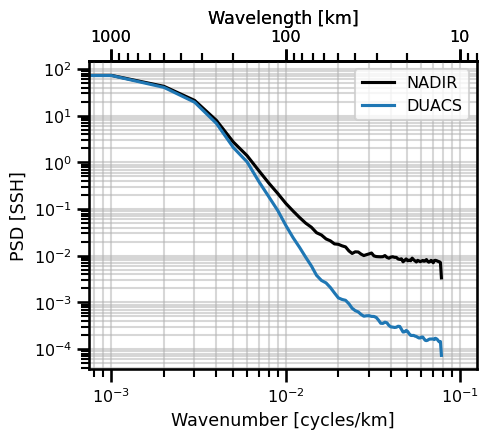

In [175]:
psd_iso_plot = PlotPSDIsotropic()
psd_iso_plot.init_fig()
psd_iso_plot.plot_both(
    ds_psd.ssh,
    freq_scale=1, 
    units="km",
    label="NADIR",
    color="black",
)
psd_iso_plot.plot_both(
    ds_psd.ssh_interp,
    freq_scale=1, 
    units="km",
    label="DUACS",
    color="tab:blue",
)

# set custom bounds
psd_iso_plot.ax.set_xlim((10**(-3) - 0.00025, 10**(-1) +0.025))
psd_iso_plot.ax.set_ylabel("PSD [SSH]")

plt.show()

In [176]:
from oceanbench._src.metrics.utils import find_intercept_1D, find_intercept_2D

In [180]:
class PlotPSDScoreIsotropic(PlotPSDIsotropic):
    
    def _add_score(
        self,
        da,
        freq_scale=1.0, 
        units=None, 
        threshhold: float=0.5, 
        threshhold_color="k",
        name=""
):
        
        dim = da.dims[0]
        self.ax.set(ylabel="PSD Score", yscale="linear")
        self.ax.set_ylim((0,1.0))
        self.ax.set_xlim((
            10**(-3) - 0.00025,
            10**(-1) +0.025,
        ))
        
        resolved_scale = freq_scale / find_intercept_1D(
            x=da.values, y=1./da[dim].values, level=threshhold
        )        
        self.ax.vlines(
            x=resolved_scale, 
            ymin=0, ymax=threshhold, 
            color=threshhold_color,
            linewidth=2, linestyle="--",
        )
        self.ax.hlines(
            y=threshhold,
            xmin=np.ma.min(np.ma.masked_invalid(da[dim].values * freq_scale)),
            xmax=resolved_scale, color=threshhold_color,
            linewidth=2, linestyle="--"
        )        
        label = f"{name}: {1/resolved_scale:.0f} {units} "
        self.ax.scatter(
            resolved_scale, threshhold,
            color=threshhold_color, marker=".",
            linewidth=5, label=label,
            zorder=3
        )
        
        
    def plot_score(
        self, 
        da, 
        freq_scale=1.0, 
        units=None, 
        threshhold: float=0.5, 
        threshhold_color="k",
        name="",
        **kwargs
    ):
        
        self.plot_both(da=da, freq_scale=freq_scale, units=units, **kwargs)
        self._add_score(
            da=da, 
            freq_scale=freq_scale,
            units=units,
            threshhold=threshhold, 
            threshhold_color=threshhold_color,
            name=name
        )

In [181]:
find_intercept_1D(
            x=ds_psd.score.values, 
    y=1./(ds_psd.score.wavenumber+1e-15), 
    level=0.5,
    kind="slinear"
)        

array(150.40908832)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2464280/910031034.py:22: RuntimeWarning: divide by zero encountered in true_divide
  x=da.values, y=1./da[dim].values, level=threshhold


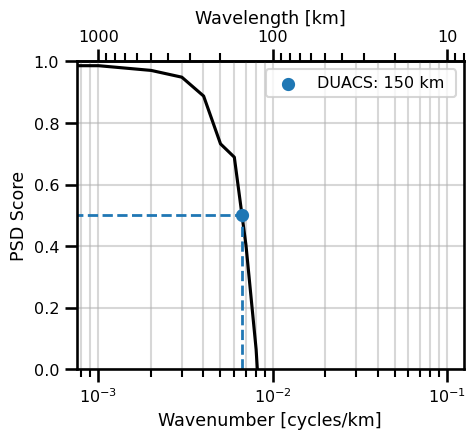

In [182]:
psd_iso_plot = PlotPSDScoreIsotropic()
psd_iso_plot.init_fig()
psd_iso_plot.plot_score(
    ds_psd.score,
    freq_scale=1, 
    units="km",
    name="DUACS",
    color="black",
    threshhold=0.5,
    threshhold_color="tab:blue"
    
)
plt.legend()
plt.show()

## Segments

## PSD Analysis